# Project Outline - Water Quality

- Water Quality Dataset from Kaggel - https://www.kaggle.com/adityakadiwal/water-potability

- Predicting podability based on existing features without potability feature

- Testing our predictions on original database potability feature

- Create a feature that is MORE then binary for potability

In [1]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns
import plotly.express    as px
import scipy.stats       as stats
import pydotplus

from six                  import StringIO
from IPython.display      import Image
from data.ds_models       import ds_models

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline                import Pipeline
from sklearn.impute                  import SimpleImputer, KNNImputer
from sklearn.preprocessing           import StandardScaler, OneHotEncoder, normalize
from sklearn.model_selection         import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics                 import mean_squared_error, mean_squared_log_error, accuracy_score
from sklearn.metrics                 import plot_confusion_matrix, classification_report

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors    import KNeighborsClassifier
from sklearn.naive_bayes  import GaussianNB
from sklearn.tree         import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble     import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble     import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm          import SVC

import warnings
warnings.filterwarnings('ignore')

# Data Exploration and Cleaning

In [2]:
df = pd.read_csv('data/water_potability.csv')

In [3]:
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


### Raw Potability Histogram

(array([1998.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1278.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

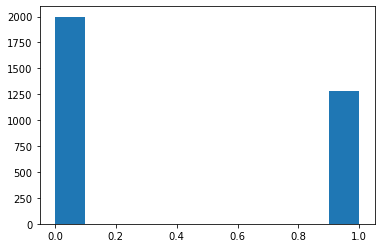

In [4]:
plt.hist(df['Potability'])

### Cleaning NaN values

In [5]:
df.isna().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [6]:
df_scrub = df.dropna()
df_scrub.isna().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

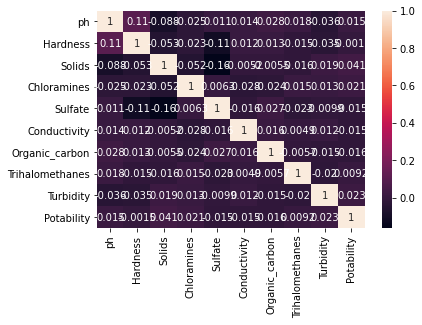

In [7]:
sns.heatmap(df_scrub.corr(), annot=True);

In [8]:
df_scrub.corr()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
ph,1.000000,0.108948,-0.087615,-0.024768,0.010524,0.014128,0.028375,0.018278,-0.035849,0.014530
Hardness,0.108948,1.000000,-0.053269,-0.022685,-0.108521,0.011731,0.013224,-0.015400,-0.034831,-0.001505
Solids,-0.087615,-0.053269,1.000000,-0.051789,-0.162769,-0.005198,-0.005484,-0.015668,0.019409,0.040674
Chloramines,-0.024768,-0.022685,-0.051789,1.000000,0.006254,-0.028277,-0.023808,0.014990,0.013137,0.020784
Sulfate,0.010524,-0.108521,-0.162769,0.006254,1.000000,-0.016192,0.026776,-0.023347,-0.009934,-0.015303
Conductivity,0.014128,0.011731,-0.005198,-0.028277,-0.016192,1.000000,0.015647,0.004888,0.012495,-0.015496
Organic_carbon,0.028375,0.013224,-0.005484,-0.023808,0.026776,0.015647,1.000000,-0.005667,-0.015428,-0.015567
Trihalomethanes,0.018278,-0.015400,-0.015668,0.014990,-0.023347,0.004888,-0.005667,1.000000,-0.020497,0.009244
Turbidity,-0.035849,-0.034831,0.019409,0.013137,-0.009934,0.012495,-0.015428,-0.020497,1.000000,0.022682
Potability,0.014530,-0.001505,0.040674,0.020784,-0.015303,-0.015496,-0.015567,0.009244,0.022682,1.000000


In [9]:
df_scrub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2011 entries, 3 to 3271
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2011 non-null   float64
 1   Hardness         2011 non-null   float64
 2   Solids           2011 non-null   float64
 3   Chloramines      2011 non-null   float64
 4   Sulfate          2011 non-null   float64
 5   Conductivity     2011 non-null   float64
 6   Organic_carbon   2011 non-null   float64
 7   Trihalomethanes  2011 non-null   float64
 8   Turbidity        2011 non-null   float64
 9   Potability       2011 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 172.8 KB


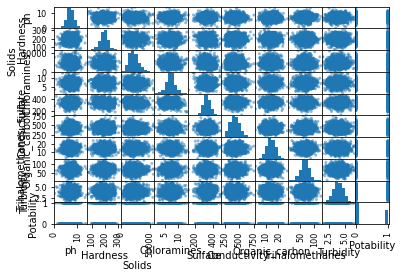

In [10]:
pd.plotting.scatter_matrix(df_scrub);

In [11]:
X = df_scrub.drop(columns=['Potability'], axis=1)

## Removing Outliers

In [12]:
#Q1 = df_scrub.quantile(0.25)
#Q3 = df_scrub.quantile(0.75)
#IQR = df_scrub.apply(stats.iqr)
#df_out = df_scrub[~((X < (Q1-1.5*IQR)) | (X > Q3+1.5*IQR)).any(axis=1)]
#df_out

In [13]:
#df_out.corr()

### Clean Potability Histogram

In [14]:
#plt.hist(df1['Potability'])

# Data Instantiation

### Raw Data

In [15]:
X = df.drop(columns=['Potability'], axis=1)
y = df['Potability']

### Dropping NaNs Data

In [16]:
df_dn = df.dropna()
X_dn  = df_dn.drop(columns=['Potability'], axis=1)
y_dn  = df_dn['Potability']

### Dropping Outliers Data

In [17]:



#X_do = df.drop(columns=['Potability'], axis=1)
#y_do = df['Potability']

# Model Instantiations

## Gaussian Naive Bayes

In [18]:
#model = GaussianNB()

#model = BaggingClassifier(GaussianNB())

#model = AdaBoostClassifier(GaussianNB())

## KNeighbors Classifier

In [19]:
#model      = KNeighborsClassifier()

#knc_grid   = {'n_neighbors': [1, 2, 3, 4, 5], 'weights': ['uniform', 'distance']}
#model      = GridSearchCV(KNeighborsClassifier(), knc_grid, scoring='accuracy', verbose=1)

#model      = AdaBoostClassifier(KNeighborsClassifier())

## Logistic Regression

In [20]:
#model       = LogisticRegression(fit_intercept = False, C = 1e12, solver='lbfgs', multi_class='auto')

#logreg_grid = {'C': [1, 2, 3], 'solver': [‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’]}
#model       = GridSearchCV(LogisticRegression(), logreg_grid, scoring='accuracy', verbose=1)

## Decision Tree Classifier

In [21]:
#model    = DecisionTreeClassifier()

#dtc_grid = {'criterion': ['gini', 'entropy'], 'max_depth':[1, 2, 3, 4, 5]}
#model    = GridSearchCV(DecisionTreeClassifier(), dtc_grid, scoring='accuracy', verbose=1)

## Bagging Classifier

In [22]:
#model   = BaggingClassifier()

#bc_grid = {'n_estimators': [10, 20, 30, 40, 50], 'oob_score':['True', 'False']}
#model   = GridSearchCV(BaggingClassifier(), bc_grid, scoring='accuracy', verbose=1)

## Random Forest Classifier

In [23]:
#model    = RandomForestClassifier()

#rfc_grid = {'n_estimators': [100, 200], 'criterion':['gini', 'entropy'], 
#            'oob_score':['True', 'False'], 'max_depth': [3, 4, 5, 6, 7, 8]}
#model    = GridSearchCV(RandomForestClassifier(), rfc_grid, scoring='accuracy', verbose=1)

## Adaptive Boosting Classifier

In [24]:
#model = AdaBoostClassifier()

## Gradient Boosting Classifier

In [25]:
#model = GradientBoostingClassifier()

## Support Vector Classification

In [26]:
#model    = SVC()

#svc_grid = {'C': [1, 2, 3], 'kernel': [‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’]}
#model    = GridSearchCV(SVC(), svc_grid, scoring='accuracy', verbose=1)

# Model Testing 

### Gaussian Naive Bayes - NaNs Filled w/KNN - 61% Test Accuracy

Gaussian Naive Bayes - NaNs Filled w/KNN Train Data Confusion Matrix:



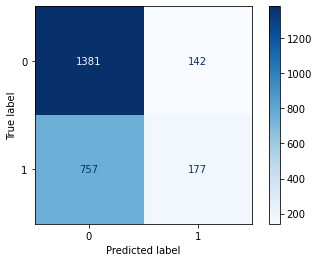

Gaussian Naive Bayes - NaNs Filled w/KNN Test Data Confusion Matrix:



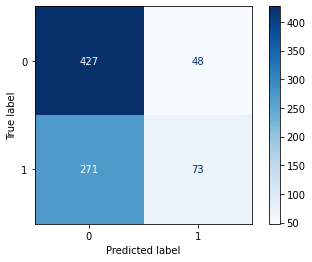

Gaussian Naive Bayes - NaNs Filled w/KNN Train Report:

              precision    recall  f1-score   support

           0       0.65      0.91      0.75      1523
           1       0.55      0.19      0.28       934

    accuracy                           0.63      2457
   macro avg       0.60      0.55      0.52      2457
weighted avg       0.61      0.63      0.58      2457

Gaussian Naive Bayes - NaNs Filled w/KNN Test Report:

              precision    recall  f1-score   support

           0       0.61      0.90      0.73       475
           1       0.60      0.21      0.31       344

    accuracy                           0.61       819
   macro avg       0.61      0.56      0.52       819
weighted avg       0.61      0.61      0.55       819



In [27]:
model = GaussianNB()

gnb   = ds_models(model, X, y, model_name='Gaussian Naive Bayes - NaNs Filled w/KNN',
                  output='class', imputer=True)


In [71]:
gnb

GaussianNB()

### Gaussian Naive Bayes - NaNs Filled w/KNN - Bagging Classifier - 62% Test Accuracy

Gaussian Naive Bayes - NaNs w/KNN - Bagging Classifier Train Data Confusion Matrix:



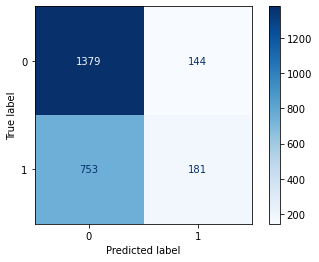

Gaussian Naive Bayes - NaNs w/KNN - Bagging Classifier Test Data Confusion Matrix:



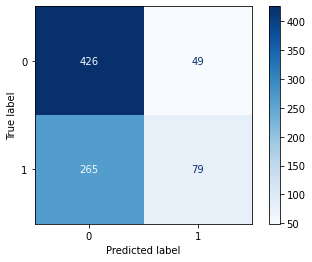

Gaussian Naive Bayes - NaNs w/KNN - Bagging Classifier Train Report:

              precision    recall  f1-score   support

           0       0.65      0.91      0.75      1523
           1       0.56      0.19      0.29       934

    accuracy                           0.63      2457
   macro avg       0.60      0.55      0.52      2457
weighted avg       0.61      0.63      0.58      2457

Gaussian Naive Bayes - NaNs w/KNN - Bagging Classifier Test Report:

              precision    recall  f1-score   support

           0       0.62      0.90      0.73       475
           1       0.62      0.23      0.33       344

    accuracy                           0.62       819
   macro avg       0.62      0.56      0.53       819
weighted avg       0.62      0.62      0.56       819



In [29]:
model  = BaggingClassifier(GaussianNB())

gnb_bc = ds_models(model, X, y, model_name='Gaussian Naive Bayes - NaNs w/KNN - Bagging Classifier',
                   output='class', imputer=True)


In [30]:
gnb_bc

BaggingClassifier(base_estimator=GaussianNB())

### Gaussian Naive Bayes - NaNs Filled w/KNN - Adaptive Boosting Classifier - 52% Test Accuracy

Gaussian Naive Bayes - NaNs w/KNN - Adaptive Boosting Classifier Train Data Confusion Matrix:



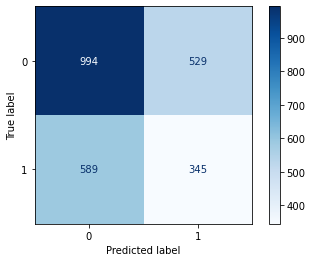

Gaussian Naive Bayes - NaNs w/KNN - Adaptive Boosting Classifier Test Data Confusion Matrix:



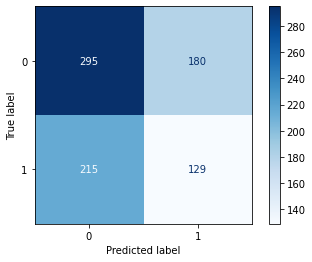

Gaussian Naive Bayes - NaNs w/KNN - Adaptive Boosting Classifier Train Report:

              precision    recall  f1-score   support

           0       0.63      0.65      0.64      1523
           1       0.39      0.37      0.38       934

    accuracy                           0.54      2457
   macro avg       0.51      0.51      0.51      2457
weighted avg       0.54      0.54      0.54      2457

Gaussian Naive Bayes - NaNs w/KNN - Adaptive Boosting Classifier Test Report:

              precision    recall  f1-score   support

           0       0.58      0.62      0.60       475
           1       0.42      0.38      0.40       344

    accuracy                           0.52       819
   macro avg       0.50      0.50      0.50       819
weighted avg       0.51      0.52      0.51       819



In [31]:
model   = AdaBoostClassifier(GaussianNB())

gnb_abc = ds_models(model, X, y, model_name='Gaussian Naive Bayes - NaNs w/KNN - Adaptive Boosting Classifier',
                    output='class', imputer=True)


In [32]:
gnb_abc

AdaBoostClassifier(base_estimator=GaussianNB())

### Gaussian Naive Bayes - Dropped NaNs - 62% Test Accuracy

Gaussian Naive Bayes - Dropped NaNs Train Data Confusion Matrix:



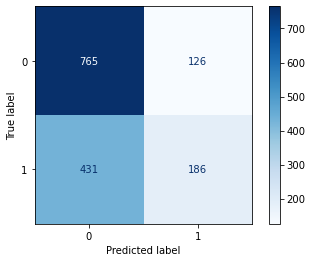

Gaussian Naive Bayes - Dropped NaNs Test Data Confusion Matrix:



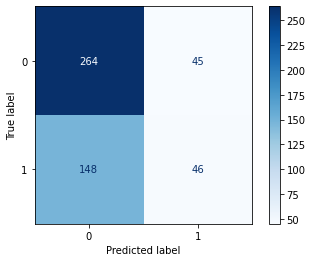

Gaussian Naive Bayes - Dropped NaNs Train Report:

              precision    recall  f1-score   support

           0       0.64      0.86      0.73       891
           1       0.60      0.30      0.40       617

    accuracy                           0.63      1508
   macro avg       0.62      0.58      0.57      1508
weighted avg       0.62      0.63      0.60      1508

Gaussian Naive Bayes - Dropped NaNs Test Report:

              precision    recall  f1-score   support

           0       0.64      0.85      0.73       309
           1       0.51      0.24      0.32       194

    accuracy                           0.62       503
   macro avg       0.57      0.55      0.53       503
weighted avg       0.59      0.62      0.57       503



In [33]:
model  = GaussianNB()

gnb_dn = ds_models(model, X_dn, y_dn, model_name='Gaussian Naive Bayes - Dropped NaNs',
                   output='class')


In [34]:
gnb_dn

GaussianNB()

### Gaussian Naive Bayes - Dropped NaNs - Bagging Classifier - 61% Test Accuracy

Gaussian Naive Bayes - Dropped NaNs - Bagging Classifier Train Data Confusion Matrix:



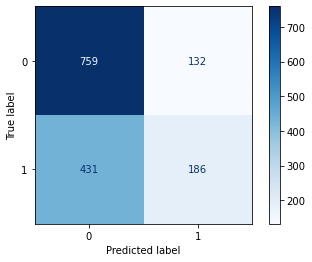

Gaussian Naive Bayes - Dropped NaNs - Bagging Classifier Test Data Confusion Matrix:



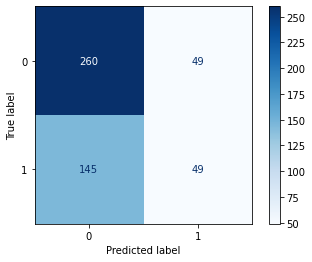

Gaussian Naive Bayes - Dropped NaNs - Bagging Classifier Train Report:

              precision    recall  f1-score   support

           0       0.64      0.85      0.73       891
           1       0.58      0.30      0.40       617

    accuracy                           0.63      1508
   macro avg       0.61      0.58      0.56      1508
weighted avg       0.62      0.63      0.59      1508

Gaussian Naive Bayes - Dropped NaNs - Bagging Classifier Test Report:

              precision    recall  f1-score   support

           0       0.64      0.84      0.73       309
           1       0.50      0.25      0.34       194

    accuracy                           0.61       503
   macro avg       0.57      0.55      0.53       503
weighted avg       0.59      0.61      0.58       503



In [35]:
model     = BaggingClassifier(GaussianNB())

gnb_dn_bc = ds_models(model, X_dn, y_dn, model_name='Gaussian Naive Bayes - Dropped NaNs - Bagging Classifier',
                      output='class')


In [36]:
gnb_dn_bc

BaggingClassifier(base_estimator=GaussianNB())

### Gaussian Naive Bayes - Dropped NaNs - Adaptive Boosting Classifier - 61% Test Accuracy

Gaussian Naive Bayes - Dropped NaNs - Adaptive Boosting Classifier Train Data Confusion Matrix:



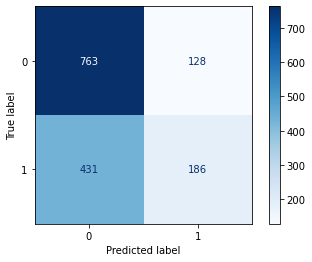

Gaussian Naive Bayes - Dropped NaNs - Adaptive Boosting Classifier Test Data Confusion Matrix:



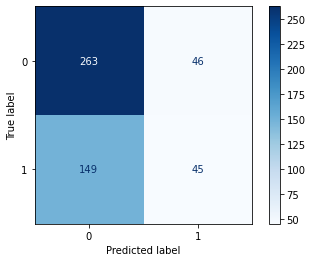

Gaussian Naive Bayes - Dropped NaNs - Adaptive Boosting Classifier Train Report:

              precision    recall  f1-score   support

           0       0.64      0.86      0.73       891
           1       0.59      0.30      0.40       617

    accuracy                           0.63      1508
   macro avg       0.62      0.58      0.57      1508
weighted avg       0.62      0.63      0.60      1508

Gaussian Naive Bayes - Dropped NaNs - Adaptive Boosting Classifier Test Report:

              precision    recall  f1-score   support

           0       0.64      0.85      0.73       309
           1       0.49      0.23      0.32       194

    accuracy                           0.61       503
   macro avg       0.57      0.54      0.52       503
weighted avg       0.58      0.61      0.57       503



In [37]:
model      = BaggingClassifier(GaussianNB())

gnb_dn_abc = ds_models(model, X_dn, y_dn, model_name='Gaussian Naive Bayes - Dropped NaNs - Adaptive Boosting Classifier',
                       output='class')


In [38]:
gnb_dn_abc

BaggingClassifier(base_estimator=GaussianNB())

### Decision Tree Classifier - NaNs Filled w/KNN - 59% Test Accuracy

Decision Tree Classifier - NaNs Filled w/KNN Train Data Confusion Matrix:



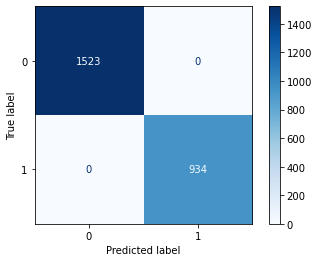

Decision Tree Classifier - NaNs Filled w/KNN Test Data Confusion Matrix:



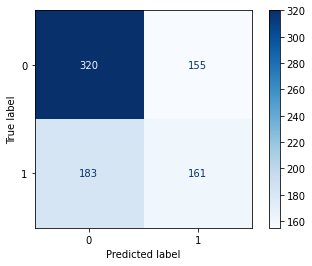

Decision Tree Classifier - NaNs Filled w/KNN Train Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1523
           1       1.00      1.00      1.00       934

    accuracy                           1.00      2457
   macro avg       1.00      1.00      1.00      2457
weighted avg       1.00      1.00      1.00      2457

Decision Tree Classifier - NaNs Filled w/KNN Test Report:

              precision    recall  f1-score   support

           0       0.64      0.67      0.65       475
           1       0.51      0.47      0.49       344

    accuracy                           0.59       819
   macro avg       0.57      0.57      0.57       819
weighted avg       0.58      0.59      0.58       819

Feature Importances:

[0.15398504 0.13948803 0.11109589 0.12190236 0.12651483 0.06647375
 0.0809571  0.08577186 0.11381114]


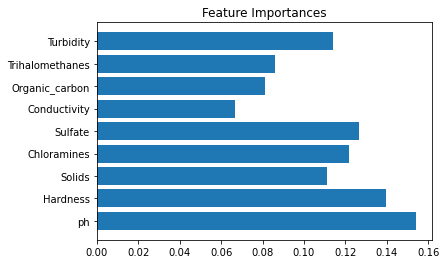

In [39]:
model = DecisionTreeClassifier()

dtc   = ds_models(model, X, y, model_name='Decision Tree Classifier - NaNs Filled w/KNN',
                  output='class', imputer=True, fi=True)


In [40]:
dtc

DecisionTreeClassifier()

### Decision Tree Classifier - NaNs Filled w/KNN - Gridsearch - 62% Test Accuracy

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.5s finished


Decision Tree Classifier - NaNs w/KNN - Gridsearch Train Data Confusion Matrix:



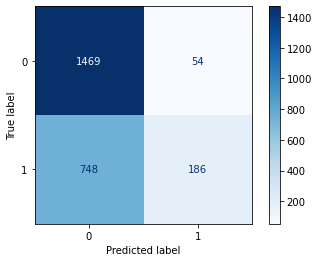

Decision Tree Classifier - NaNs w/KNN - Gridsearch Test Data Confusion Matrix:



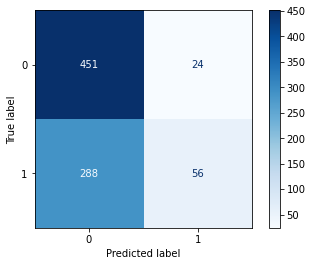

Decision Tree Classifier - NaNs w/KNN - Gridsearch Train Report:

              precision    recall  f1-score   support

           0       0.66      0.96      0.79      1523
           1       0.78      0.20      0.32       934

    accuracy                           0.67      2457
   macro avg       0.72      0.58      0.55      2457
weighted avg       0.71      0.67      0.61      2457

Decision Tree Classifier - NaNs w/KNN - Gridsearch Test Report:

              precision    recall  f1-score   support

           0       0.61      0.95      0.74       475
           1       0.70      0.16      0.26       344

    accuracy                           0.62       819
   macro avg       0.66      0.56      0.50       819
weighted avg       0.65      0.62      0.54       819



In [41]:
dtc_grid = {'criterion': ['gini', 'entropy'], 'max_depth':[1, 2, 3, 4, 5]}
model    = GridSearchCV(DecisionTreeClassifier(), dtc_grid, scoring='accuracy', verbose=1)

dtc_gs   = ds_models(model, X, y, model_name='Decision Tree Classifier - NaNs w/KNN - Gridsearch',
                     output='class', imputer=True)


In [42]:
dtc_gs

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5]},
             scoring='accuracy', verbose=1)

### Decision Tree Classifier - Dropped NaNs - 64% Test Accuracy

Decision Tree Classifier - Dropped NaNs Train Data Confusion Matrix:



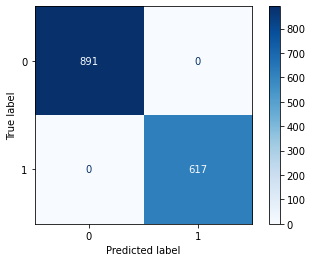

Decision Tree Classifier - Dropped NaNs Test Data Confusion Matrix:



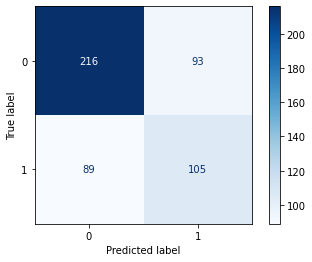

Decision Tree Classifier - Dropped NaNs Train Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       891
           1       1.00      1.00      1.00       617

    accuracy                           1.00      1508
   macro avg       1.00      1.00      1.00      1508
weighted avg       1.00      1.00      1.00      1508

Decision Tree Classifier - Dropped NaNs Test Report:

              precision    recall  f1-score   support

           0       0.71      0.70      0.70       309
           1       0.53      0.54      0.54       194

    accuracy                           0.64       503
   macro avg       0.62      0.62      0.62       503
weighted avg       0.64      0.64      0.64       503

Feature Importances:

[0.18079628 0.09597059 0.10471845 0.13074823 0.12001834 0.0744105
 0.12118154 0.09663551 0.07552055]


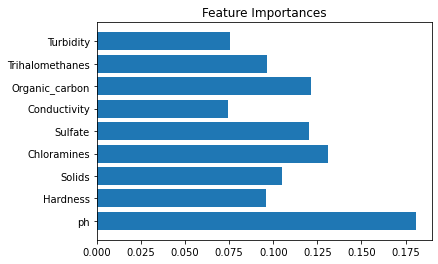

In [43]:
model  = DecisionTreeClassifier()

dtc_dn = ds_models(model, X_dn, y_dn, model_name='Decision Tree Classifier - Dropped NaNs',
                   output='class', fi=True)


In [44]:
dtc_dn

DecisionTreeClassifier()

### Decision Tree Classifier - Dropped NaNs - Gridsearch - 62% Test Accuracy

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.7s finished


Decision Tree Classifier - Dropped NaNs - Gridsearch Train Data Confusion Matrix:



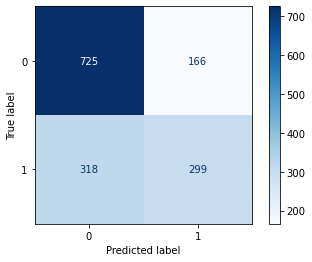

Decision Tree Classifier - Dropped NaNs - Gridsearch Test Data Confusion Matrix:



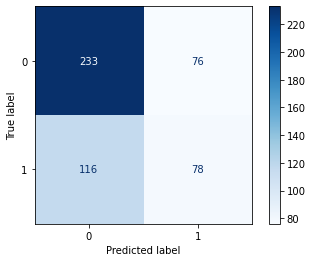

Decision Tree Classifier - Dropped NaNs - Gridsearch Train Report:

              precision    recall  f1-score   support

           0       0.70      0.81      0.75       891
           1       0.64      0.48      0.55       617

    accuracy                           0.68      1508
   macro avg       0.67      0.65      0.65      1508
weighted avg       0.67      0.68      0.67      1508

Decision Tree Classifier - Dropped NaNs - Gridsearch Test Report:

              precision    recall  f1-score   support

           0       0.67      0.75      0.71       309
           1       0.51      0.40      0.45       194

    accuracy                           0.62       503
   macro avg       0.59      0.58      0.58       503
weighted avg       0.61      0.62      0.61       503



In [45]:
dtc_grid  = {'criterion': ['gini', 'entropy'], 'max_depth':[1, 2, 3, 4, 5]}
model     = GridSearchCV(DecisionTreeClassifier(), dtc_grid, scoring='accuracy', verbose=1)

dtc_dn_gs = ds_models(model, X_dn, y_dn, model_name='Decision Tree Classifier - Dropped NaNs - Gridsearch',
                      output='class')


In [46]:
dtc_dn_gs

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5]},
             scoring='accuracy', verbose=1)

### Bagging Classifier - NaNs Filled w/KNN - 63% Test Accuracy

Bagging Classifier - NaNs Filled w/KNN Train Data Confusion Matrix:



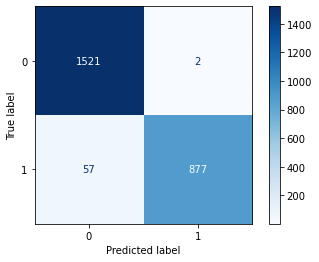

Bagging Classifier - NaNs Filled w/KNN Test Data Confusion Matrix:



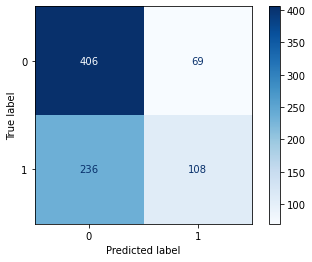

Bagging Classifier - NaNs Filled w/KNN Train Report:

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1523
           1       1.00      0.94      0.97       934

    accuracy                           0.98      2457
   macro avg       0.98      0.97      0.97      2457
weighted avg       0.98      0.98      0.98      2457

Bagging Classifier - NaNs Filled w/KNN Test Report:

              precision    recall  f1-score   support

           0       0.63      0.85      0.73       475
           1       0.61      0.31      0.41       344

    accuracy                           0.63       819
   macro avg       0.62      0.58      0.57       819
weighted avg       0.62      0.63      0.60       819



In [47]:
model = BaggingClassifier()

bc    = ds_models(model, X, y, model_name='Bagging Classifier - NaNs Filled w/KNN',
                  output='class', imputer=True)


In [48]:
bc

BaggingClassifier()

### Bagging Classifier - NaNs Filled w/KNN - Gridsearch - 64% Test Accuracy

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   28.8s finished


Bagging Classifier - NaNs w/KNN- Gridsearch Train Data Confusion Matrix:



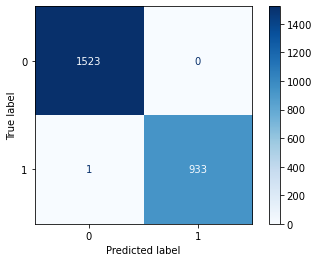

Bagging Classifier - NaNs w/KNN- Gridsearch Test Data Confusion Matrix:



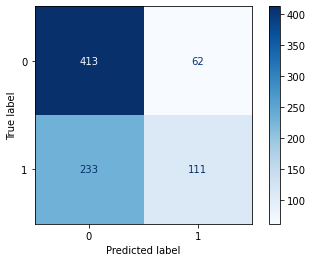

Bagging Classifier - NaNs w/KNN- Gridsearch Train Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1523
           1       1.00      1.00      1.00       934

    accuracy                           1.00      2457
   macro avg       1.00      1.00      1.00      2457
weighted avg       1.00      1.00      1.00      2457

Bagging Classifier - NaNs w/KNN- Gridsearch Test Report:

              precision    recall  f1-score   support

           0       0.64      0.87      0.74       475
           1       0.64      0.32      0.43       344

    accuracy                           0.64       819
   macro avg       0.64      0.60      0.58       819
weighted avg       0.64      0.64      0.61       819



In [49]:
bc_grid = {'n_estimators': [10, 20, 30, 40, 50], 'oob_score':['True', 'False']}
model   = GridSearchCV(BaggingClassifier(), bc_grid, scoring='accuracy', verbose=1)

bc_gs   = ds_models(model, X, y, model_name='Bagging Classifier - NaNs w/KNN- Gridsearch',
                    output='class', imputer=True)


In [50]:
bc_gs

GridSearchCV(estimator=BaggingClassifier(),
             param_grid={'n_estimators': [10, 20, 30, 40, 50],
                         'oob_score': ['True', 'False']},
             scoring='accuracy', verbose=1)

### Bagging Classifier - Dropped NaNs - 66% Test Accuracy

Bagging Classifier - Dropped NaNs Train Data Confusion Matrix:



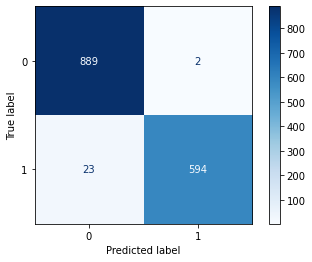

Bagging Classifier - Dropped NaNs Test Data Confusion Matrix:



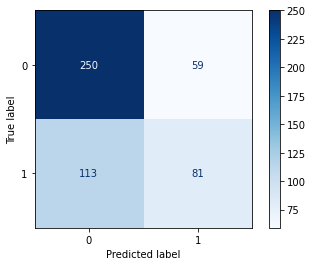

Bagging Classifier - Dropped NaNs Train Report:

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       891
           1       1.00      0.96      0.98       617

    accuracy                           0.98      1508
   macro avg       0.99      0.98      0.98      1508
weighted avg       0.98      0.98      0.98      1508

Bagging Classifier - Dropped NaNs Test Report:

              precision    recall  f1-score   support

           0       0.69      0.81      0.74       309
           1       0.58      0.42      0.49       194

    accuracy                           0.66       503
   macro avg       0.63      0.61      0.61       503
weighted avg       0.65      0.66      0.64       503



In [51]:
model = BaggingClassifier()

bc_dn = ds_models(model, X_dn, y_dn, model_name='Bagging Classifier - Dropped NaNs',
                  output='class')


In [52]:
bc_dn

BaggingClassifier()

### Bagging Classifier - Dropped NaNs - Gridsearch - 70% Test Accuracy

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   17.6s finished


Bagging Classifier - Dropped NaNs - Gridsearch Train Data Confusion Matrix:



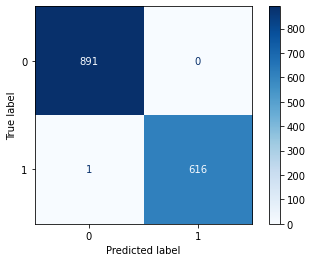

Bagging Classifier - Dropped NaNs - Gridsearch Test Data Confusion Matrix:



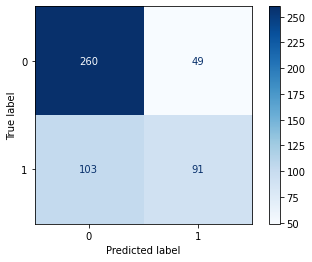

Bagging Classifier - Dropped NaNs - Gridsearch Train Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       891
           1       1.00      1.00      1.00       617

    accuracy                           1.00      1508
   macro avg       1.00      1.00      1.00      1508
weighted avg       1.00      1.00      1.00      1508

Bagging Classifier - Dropped NaNs - Gridsearch Test Report:

              precision    recall  f1-score   support

           0       0.72      0.84      0.77       309
           1       0.65      0.47      0.54       194

    accuracy                           0.70       503
   macro avg       0.68      0.66      0.66       503
weighted avg       0.69      0.70      0.69       503



In [53]:
bc_grid  = {'n_estimators': [10, 20, 30, 40, 50], 'oob_score':['True', 'False']}
model    = GridSearchCV(BaggingClassifier(), bc_grid, scoring='accuracy', verbose=1)

bc_dn_gs = ds_models(model, X_dn, y_dn, model_name='Bagging Classifier - Dropped NaNs - Gridsearch',
                     output='class')


In [54]:
bc_dn_gs

GridSearchCV(estimator=BaggingClassifier(),
             param_grid={'n_estimators': [10, 20, 30, 40, 50],
                         'oob_score': ['True', 'False']},
             scoring='accuracy', verbose=1)

### Random Forest Classifier - NaNs Filled w/KNN - 65% Test Accuracy

Randmon Forest Classifier - NaNs Filled w/KNN Train Data Confusion Matrix:



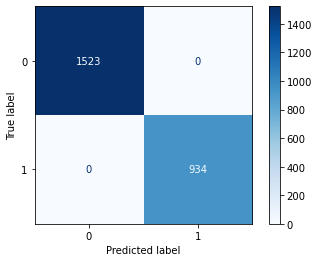

Randmon Forest Classifier - NaNs Filled w/KNN Test Data Confusion Matrix:



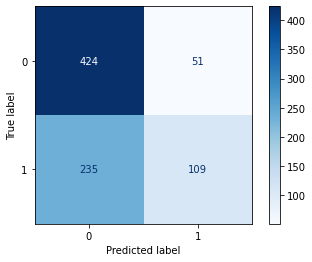

Randmon Forest Classifier - NaNs Filled w/KNN Train Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1523
           1       1.00      1.00      1.00       934

    accuracy                           1.00      2457
   macro avg       1.00      1.00      1.00      2457
weighted avg       1.00      1.00      1.00      2457

Randmon Forest Classifier - NaNs Filled w/KNN Test Report:

              precision    recall  f1-score   support

           0       0.64      0.89      0.75       475
           1       0.68      0.32      0.43       344

    accuracy                           0.65       819
   macro avg       0.66      0.60      0.59       819
weighted avg       0.66      0.65      0.62       819

Feature Importances:

[0.13048215 0.11675055 0.11177493 0.11291133 0.13404569 0.10225391
 0.0971294  0.09822551 0.09642652]


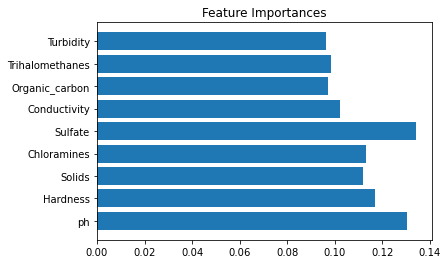

In [55]:
model = RandomForestClassifier()

rfc   = ds_models(model, X, y, model_name='Randmon Forest Classifier - NaNs Filled w/KNN',
                  output='class', imputer=True, fi=True)


In [56]:
rfc

RandomForestClassifier()

### Random Forest Classifier - NaNs Filled w/KNN - Gridsearch - 63% Test Accuracy

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  3.7min finished


Randmon Forest Classifier - NaNs w/KNN - Gridsearch Train Data Confusion Matrix:



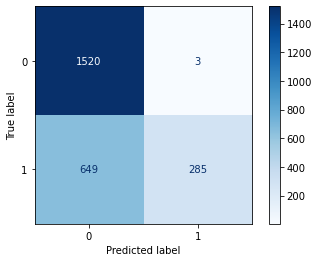

Randmon Forest Classifier - NaNs w/KNN - Gridsearch Test Data Confusion Matrix:



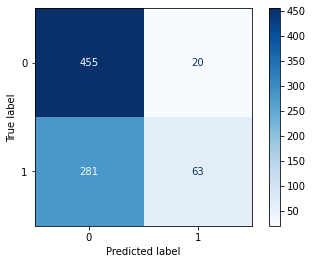

Randmon Forest Classifier - NaNs w/KNN - Gridsearch Train Report:

              precision    recall  f1-score   support

           0       0.70      1.00      0.82      1523
           1       0.99      0.31      0.47       934

    accuracy                           0.73      2457
   macro avg       0.85      0.65      0.64      2457
weighted avg       0.81      0.73      0.69      2457

Randmon Forest Classifier - NaNs w/KNN - Gridsearch Test Report:

              precision    recall  f1-score   support

           0       0.62      0.96      0.75       475
           1       0.76      0.18      0.30       344

    accuracy                           0.63       819
   macro avg       0.69      0.57      0.52       819
weighted avg       0.68      0.63      0.56       819



In [57]:
rfc_grid = {'n_estimators': [100, 200], 'criterion':['gini', 'entropy'], 
            'oob_score':['True', 'False'], 'max_depth': [3, 4, 5, 6, 7, 8]}
model    = GridSearchCV(RandomForestClassifier(), rfc_grid, scoring='accuracy', verbose=1)

rfc_gs   = ds_models(model, X, y, model_name='Randmon Forest Classifier - NaNs w/KNN - Gridsearch', 
                     output='class', imputer=True)


In [58]:
rfc_gs

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6, 7, 8],
                         'n_estimators': [100, 200],
                         'oob_score': ['True', 'False']},
             scoring='accuracy', verbose=1)

### Random Forest Classifier - Dropped NaNs - 67% Test Accuracy

Randmon Forest Classifier - Dropped NaNs Train Data Confusion Matrix:



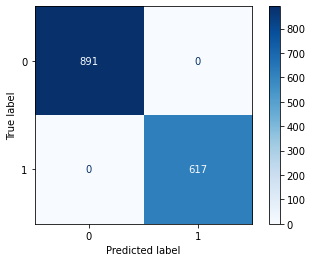

Randmon Forest Classifier - Dropped NaNs Test Data Confusion Matrix:



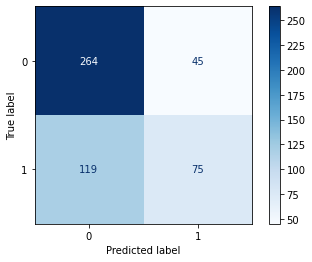

Randmon Forest Classifier - Dropped NaNs Train Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       891
           1       1.00      1.00      1.00       617

    accuracy                           1.00      1508
   macro avg       1.00      1.00      1.00      1508
weighted avg       1.00      1.00      1.00      1508

Randmon Forest Classifier - Dropped NaNs Test Report:

              precision    recall  f1-score   support

           0       0.69      0.85      0.76       309
           1       0.62      0.39      0.48       194

    accuracy                           0.67       503
   macro avg       0.66      0.62      0.62       503
weighted avg       0.66      0.67      0.65       503



In [59]:
model  = RandomForestClassifier()

rfc_dn = ds_models(model, X_dn, y_dn, model_name='Randmon Forest Classifier - Dropped NaNs',
                   output='class')

In [60]:
rfc_dn

RandomForestClassifier()

### Random Forest Classifier - Dropped NaNs - Gridsearch - 68% Test Accuracy

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  2.9min finished


Randmon Forest Classifier - Dropped NaNs - Gridsearch Train Data Confusion Matrix:



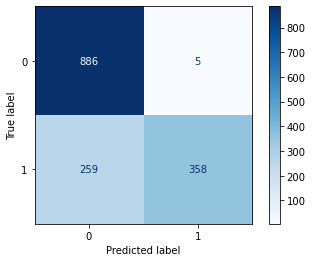

Randmon Forest Classifier - Dropped NaNs - Gridsearch Test Data Confusion Matrix:



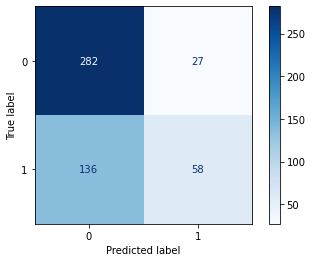

Randmon Forest Classifier - Dropped NaNs - Gridsearch Train Report:

              precision    recall  f1-score   support

           0       0.77      0.99      0.87       891
           1       0.99      0.58      0.73       617

    accuracy                           0.82      1508
   macro avg       0.88      0.79      0.80      1508
weighted avg       0.86      0.82      0.81      1508

Randmon Forest Classifier - Dropped NaNs - Gridsearch Test Report:

              precision    recall  f1-score   support

           0       0.67      0.91      0.78       309
           1       0.68      0.30      0.42       194

    accuracy                           0.68       503
   macro avg       0.68      0.61      0.60       503
weighted avg       0.68      0.68      0.64       503



In [61]:
rfc_grid  = {'n_estimators': [100, 200], 'criterion':['gini', 'entropy'], 
            'oob_score':['True', 'False'], 'max_depth': [3, 4, 5, 6, 7, 8]}
model     = GridSearchCV(RandomForestClassifier(), rfc_grid, scoring='accuracy', verbose=1)

rfc_dn_gs = ds_models(model, X_dn, y_dn, model_name='Randmon Forest Classifier - Dropped NaNs - Gridsearch', 
                      output='class')

In [62]:
rfc_dn_gs

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6, 7, 8],
                         'n_estimators': [100, 200],
                         'oob_score': ['True', 'False']},
             scoring='accuracy', verbose=1)

### Gradient Boosting Classifier - NaNs Filled w/KNN - 63% Test Accuracy

Gradient Boosting Classifier - NaNs Filled w/KNN Train Data Confusion Matrix:



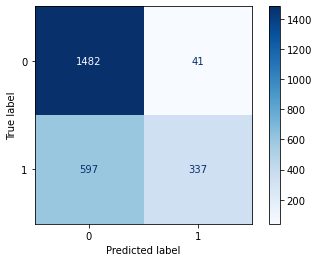

Gradient Boosting Classifier - NaNs Filled w/KNN Test Data Confusion Matrix:



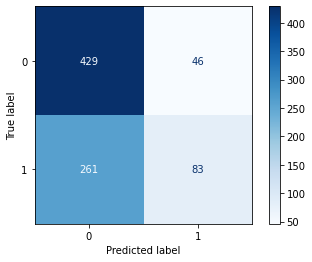

Gradient Boosting Classifier - NaNs Filled w/KNN Train Report:

              precision    recall  f1-score   support

           0       0.71      0.97      0.82      1523
           1       0.89      0.36      0.51       934

    accuracy                           0.74      2457
   macro avg       0.80      0.67      0.67      2457
weighted avg       0.78      0.74      0.71      2457

Gradient Boosting Classifier - NaNs Filled w/KNN Test Report:

              precision    recall  f1-score   support

           0       0.62      0.90      0.74       475
           1       0.64      0.24      0.35       344

    accuracy                           0.63       819
   macro avg       0.63      0.57      0.54       819
weighted avg       0.63      0.63      0.57       819

Feature Importances:

[0.22569401 0.11244467 0.11775005 0.09980104 0.205409   0.07167641
 0.05879763 0.05001155 0.05841565]


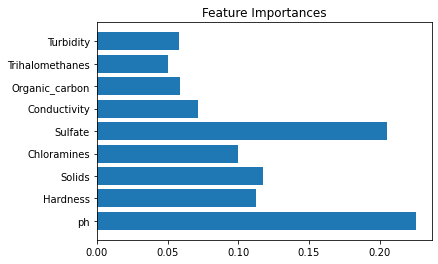

In [63]:
model = GradientBoostingClassifier()

gbc   = ds_models(model, X, y, model_name='Gradient Boosting Classifier - NaNs Filled w/KNN',
                  output='class', imputer=True, fi=True)


In [64]:
gbc

GradientBoostingClassifier()

### Gradient Boosting Classifier - Dropped NaNs - 64% Test Accuracy

Gradient Boosting Classifier - Dropped NaNs Train Data Confusion Matrix:



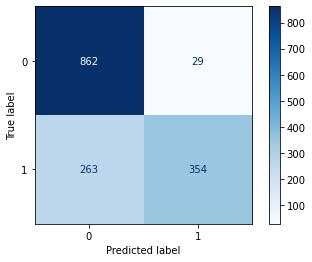

Gradient Boosting Classifier - Dropped NaNs Test Data Confusion Matrix:



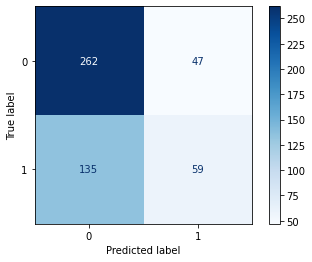

Gradient Boosting Classifier - Dropped NaNs Train Report:

              precision    recall  f1-score   support

           0       0.77      0.97      0.86       891
           1       0.92      0.57      0.71       617

    accuracy                           0.81      1508
   macro avg       0.85      0.77      0.78      1508
weighted avg       0.83      0.81      0.79      1508

Gradient Boosting Classifier - Dropped NaNs Test Report:

              precision    recall  f1-score   support

           0       0.66      0.85      0.74       309
           1       0.56      0.30      0.39       194

    accuracy                           0.64       503
   macro avg       0.61      0.58      0.57       503
weighted avg       0.62      0.64      0.61       503

Feature Importances:

[0.23958638 0.09992067 0.07547087 0.1326359  0.19720038 0.04455519
 0.07194949 0.07711737 0.06156375]


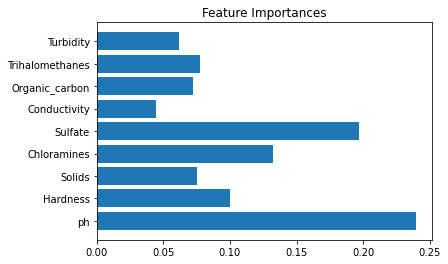

In [65]:
model  = GradientBoostingClassifier()

gbc_dn = ds_models(model, X_dn, y_dn, model_name='Gradient Boosting Classifier - Dropped NaNs',
                   output='class', fi=True)


In [66]:
gbc_dn

GradientBoostingClassifier()